# Intermediate MNIST tutorial

In [2]:
# Import important libraries
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

from timeit import default_timer as timer
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu' # For faster processing if you have a GPU

C:\Users\alexa\AppData\Local\Temp\ipykernel_14180\1332836739.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Some Helper Functions

In [3]:
def accuracy_fn(y_true, y_pred):
    correct = (y_true == y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [4]:
def plot_loss_curves(results):
    
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [5]:
def return_model(model_name, hidden_units):
    if model_name == 'baseline':
        return baseline_model()
    elif model_name == 'ffn':
        return FFN(hidden_units=hidden_units)
    elif model_name == 'alexnet':
        return AlexNet()
    else:
        return baseline_model()

We load in the data and inspect it.

In [6]:
train_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)

In [7]:
# Basic information about the training and testing dataset
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of test samples: {len(test_dataset)}')
img_train, label_train = train_dataset[0]
img_test, label_test = test_dataset[0]
print(f'Shape of each image in the training dataset: {img_train.shape}')
print(f'Shape of each image in the testing dataset: {img_test.shape}')
print(f'Number of classes: {len(train_dataset.classes)}')
print(f'Classes: {train_dataset.classes}')

Number of training samples: 60000
Number of test samples: 10000
Shape of each image in the training dataset: torch.Size([1, 28, 28])
Shape of each image in the testing dataset: torch.Size([1, 28, 28])
Number of classes: 10
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


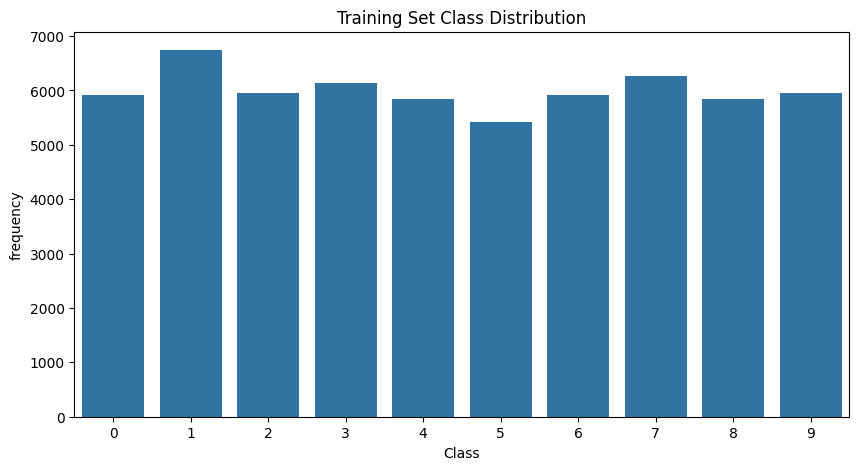

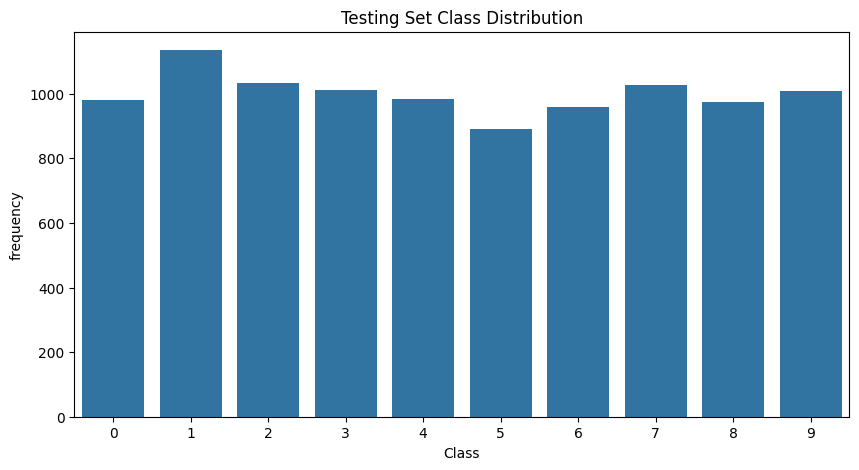

In [8]:
# Let's look at the class distribution. We want to identify whether the classes are balanced.
train_labels_df = pd.DataFrame(train_dataset.targets.numpy(), columns=['label'])
test_labels_df = pd.DataFrame(test_dataset.targets.numpy(), columns=['label'])

def plot_class_distribution(labels_df, title):
    plt.figure(figsize=(10, 5))
    sns.countplot(data=labels_df, x = 'label')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('frequency')
    plt.show()

plot_class_distribution(train_labels_df, 'Training Set Class Distribution')
plot_class_distribution(test_labels_df, 'Testing Set Class Distribution')

We see that the classes are slightly imbalanced. However, we can also observe that the imbalances are roughly similar in both datasets. This means that (at least for now) we do not have to account for the imbalances, as this imbalance also occurs in the test dataset - thus if the model does well on the imbalance in the training dataset, it hopefully also does on the testing dataset. Keep in mind that this is often not how it goes in real-life scenarios, i.e. the testing data is often not known/unavailable. This might also be important when we will augment the data.

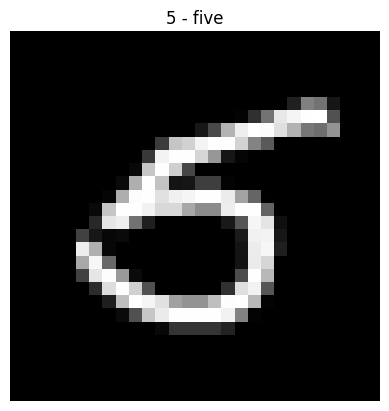

In [9]:
# We might want to set the seed to plot the same images
torch.manual_seed(1230139)

class_names = train_dataset.classes

random_idx = torch.randint(low=0, high=len(train_dataset), size=[1]).item()
img, label = train_dataset[random_idx]
plt.imshow(img.squeeze(), cmap='gray') 
plt.title(class_names[label])
plt.axis('off')
plt.show()

Without knowing the target, would you not have said this looks more like a 6 than a 5? From running the above code some times and changing the seed, we can see that most numbers look recognizable, but also that some are more difficult to guess than others. This is something we will have to take into account after our model has made predictions. It's always important to recognize that when our model makes mistakes, we *look* at these mistakes, because maybe we shouldn't call it a mistake:)

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Baseline linear model
We build a baseline linear model for comparing with later models. When we have built our pipeline we can easily compare our more complex models to this one. 

In [11]:
class baseline_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.reshape((-1, 28*28))
        return self.linear(x)

We define a training and evaluating loop. This should be generalizable for other models as well.

In [12]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device=device):
    train_loss, train_acc = 0, 0
    model.train()
    
    for X, y in data_loader:
        X, y = X.to(device), y.to(device) # We set the data to our device for faster computation.
        y_pred = model(X) # We make the predictions

        loss = loss_fn(y_pred, y) 
        acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        train_loss += loss.item()
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    # print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    
    return train_loss, train_acc

In [13]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device=device):
    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device) # We set the data to our device for faster computation.

            y_pred = model(X) # We make the predictions

            loss = loss_fn(y_pred, y)
            acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            test_loss += loss.item()
            test_acc += acc

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        # print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
    
    return test_loss, test_acc

Now we combine the training and testing step

In [14]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10,
          patience: int = 2,
          device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    
    model.to(device)
    results = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    epochs_without_improvement = 0

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        val_loss, val_acc = test_step(model=model,
                                        data_loader=val_dataloader,
                                        loss_fn=loss_fn)
        
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"val_loss: {val_loss:.4f} | "
              f"val_acc: {val_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch 
            best_model_state = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    return results, best_epoch, best_model_state

Now, we will be incorporating k-fold cross-validation for a more robust measure of performance. This is especially important when we are doing hyperparameter tuning. We will also implement Early Stopping, a regularization method that constrains the number of epochs a model can train for. This has the potential to lead to better generalization and reduces training time.

In [15]:
from torch.utils.data import Subset

def cross_validation(k, train_dataset, model_name, batch_size=64, lr=0.1, hidden_units=128):
    fold_results = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": []
        }
    
    indices = list(range(len(train_dataset)))

    if k == 1:
        split_size = int(0.8 * len(train_dataset))
        val_indices = indices[:split_size:]
        train_indices = indices[:split_size]
    else:
        split_size = len(train_dataset) // k

    for i in range(k):
        print(f"Fold {i+1}")
        
        if k > 1:
            val_indices = indices[i * split_size: (i + 1) * split_size] if (i + 1) != k else indices[i * split_size:]
            train_indices = list(set(indices) - set(val_indices))

        train_fold = Subset(train_dataset, train_indices)
        val_fold = Subset(train_dataset, val_indices)

        train_dataloader = DataLoader(train_fold, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_fold, batch_size=batch_size, shuffle=False)

        model = return_model(model_name, hidden_units=hidden_units) # Returns appropriate model based on name.
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()

        results, best_epoch, best_model_state = train(model=model, 
                        train_dataloader=train_dataloader, 
                        val_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=10,
                        patience=2) 
        
        fold_results["train_loss"].append(results["train_loss"][best_epoch])
        fold_results["train_acc"].append(results["train_acc"][best_epoch])
        fold_results["val_loss"].append(results["val_loss"][best_epoch])
        fold_results["val_acc"].append(results["val_acc"][best_epoch])
        
    avg_train_loss = np.mean(fold_results["train_loss"])
    avg_train_acc = np.mean(fold_results["train_acc"])
    avg_val_loss = np.mean(fold_results["val_loss"])
    avg_val_acc = np.mean(fold_results["val_acc"])
        
    return {
        "model_state_dict": best_model_state,
        "avg_train_loss": avg_train_loss,
        "avg_train_acc": avg_train_acc,
        "avg_val_loss": avg_val_loss,
        "avg_val_acc": avg_val_acc,
        "hyperparameters": {
            "batch_size": batch_size,
            "learning_rate": lr,
            "hidden_units": hidden_units
        }
    }

The number of epochs and the patience are kept relatively small to ensure that training time does not take too long. These (and more hyperparameters) can be adjusted to one's liking (and one's computing :))

Now we will do hyperparameter tuning with a simple feed forward neural network. Hopefully, it is now clear that it is worthwhile to make a clean training and validation pipeline before exploring more complex models. We will be using grid search for our hyperparameter search, and this is by no means exhaustive. Be sure to check out different variants than grid search and look at *which* hyperparameters you want to experiment with.

In [16]:
from itertools import product 

def hyperparameter_tuning(train_dataset, model_name, k, lrs, hidden_units_list):
    all_results = []

    for lr, hidden_units in product(lrs, hidden_units_list):
        print(f"Evaluating model with lr={lr}, hidden_units={hidden_units}")
        
        results = cross_validation(k=k,
                                train_dataset=train_dataset,
                                model_name=model_name,
                                lr=lr,
                                hidden_units=hidden_units)
        
        all_results.append(results)

    return all_results

In [17]:
class FFN(nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.layer1 = nn.Linear(28*28, hidden_units)
        self.layer2 = nn.Linear(hidden_units, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.reshape((-1, 28*28))
        return self.layer2(self.relu(self.layer1(x)))

In [18]:
k = 5
lrs = [0.05, 0.01]
hidden_units_list = [64, 128]

# Do cross validation with all combinations
# In this case I only want 4 combinations, as it otherwise takes a LONG time to train
# We can extend this search though, feel free to do so!

all_models_results = hyperparameter_tuning(train_dataset=train_dataset,
                                           model_name="ffn",
                                           k=k,
                                           lrs=lrs,
                                           hidden_units_list=hidden_units_list)

Evaluating model with lr=0.05, hidden_units=64
Fold 1


 10%|█         | 1/10 [00:15<02:21, 15.71s/it]

Epoch: 1 | train_loss: 0.6399 | train_acc: 84.1250 | val_loss: 0.3450 | val_acc: 90.4422


 20%|██        | 2/10 [00:31<02:04, 15.61s/it]

Epoch: 2 | train_loss: 0.3194 | train_acc: 90.8438 | val_loss: 0.2818 | val_acc: 92.0296


 30%|███       | 3/10 [00:46<01:49, 15.61s/it]

Epoch: 3 | train_loss: 0.2729 | train_acc: 92.2250 | val_loss: 0.2515 | val_acc: 92.9771


 30%|███       | 3/10 [00:51<01:59, 17.14s/it]


KeyboardInterrupt: 

In [ ]:
# Find the best model based on validation accuracy
best_model_info = max(all_models_results, key=lambda x: x["avg_val_acc"])

print(f"Best Model Hyperparameters: {best_model_info['hyperparameters']}")
print(f"Best Validation Accuracy: {best_model_info['avg_val_acc']:.4f}")

# Load the best model for further evaluation or deployment
best_ffn_model = return_model("ffn", hidden_units=best_model_info["hyperparameters"]["hidden_units"])
best_ffn_model.load_state_dict(best_model_info["model_state_dict"])


Best Model Hyperparameters: {'batch_size': 64, 'learning_rate': 0.05, 'hidden_units': 128}
Best Validation Accuracy: 95.8943


<All keys matched successfully>

We can compare this to our baseline model

In [ ]:
baseline_results = cross_validation(k = 1,
                                    train_dataset=train_dataset,
                                    model_name="baseline",
                                    batch_size=64,
                                    lr=0.05,
                                    hidden_units=128)

Fold 1


 10%|█         | 1/10 [00:10<01:32, 10.25s/it]

Epoch: 1 | train_loss: 0.6214 | train_acc: 85.1583 | val_loss: 0.4239 | val_acc: 88.8146


 20%|██        | 2/10 [00:20<01:21, 10.13s/it]

Epoch: 2 | train_loss: 0.3944 | train_acc: 89.3542 | val_loss: 0.3690 | val_acc: 89.8771


 30%|███       | 3/10 [00:30<01:10, 10.09s/it]

Epoch: 3 | train_loss: 0.3582 | train_acc: 90.0542 | val_loss: 0.3457 | val_acc: 90.5021


 40%|████      | 4/10 [00:40<01:00, 10.08s/it]

Epoch: 4 | train_loss: 0.3396 | train_acc: 90.5208 | val_loss: 0.3302 | val_acc: 90.9458


 50%|█████     | 5/10 [00:50<00:50, 10.17s/it]

Epoch: 5 | train_loss: 0.3274 | train_acc: 90.8729 | val_loss: 0.3208 | val_acc: 91.1125


 60%|██████    | 6/10 [01:01<00:41, 10.25s/it]

Epoch: 6 | train_loss: 0.3188 | train_acc: 91.2250 | val_loss: 0.3136 | val_acc: 91.2833


 70%|███████   | 7/10 [01:11<00:30, 10.24s/it]

Epoch: 7 | train_loss: 0.3124 | train_acc: 91.3000 | val_loss: 0.3069 | val_acc: 91.4667


 80%|████████  | 8/10 [01:21<00:20, 10.18s/it]

Epoch: 8 | train_loss: 0.3071 | train_acc: 91.4542 | val_loss: 0.3029 | val_acc: 91.5875


 90%|█████████ | 9/10 [01:31<00:10, 10.15s/it]

Epoch: 9 | train_loss: 0.3026 | train_acc: 91.6271 | val_loss: 0.2987 | val_acc: 91.6292


100%|██████████| 10/10 [01:41<00:00, 10.15s/it]

Epoch: 10 | train_loss: 0.2991 | train_acc: 91.6771 | val_loss: 0.2950 | val_acc: 91.7771


In [ ]:
baseline_results["avg_val_acc"], best_model_info["avg_val_acc"]

(91.77708333333334, 95.89428191489363)

As we can see, there is a substantial improvement from our baseline model to our very simple feedforward neural network.

AlexNet was the first 'modern' Convolutional Neural Network. I have edited it so that it works for 28 x 28 images. Now that we've made our entire pipeline, it is very easy to try models like these :)

What is important to note about this is that we are now using Convolutional neural networks, which utilize the spatial relationships between the pixels. Our baseline model and simple FFN both do not look at this, as our images are flattened into vectors. This model is the first model which we cover that *doesn't* do this. This allows the model to find more intricate patterns in the images, and draws how we see the world! For more information on this, check out the wonderful chapter on CNNs: https://d2l.ai/chapter_convolutional-neural-networks/index.html 

We can use LazyLinear layers which allow us to only have to worry about the output dimensionality of each layer. 

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(24, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(24, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), nn.Flatten(),
            nn.LazyLinear(256), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(128), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
alexnet_results = cross_validation(k = 1,
                                   train_dataset=train_dataset,
                                   model_name="alexnet",
                                   batch_size=64,
                                   lr=0.05,
                                   hidden_units=128)

c:\Python311\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Fold 1


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:14<02:11, 14.64s/it]

Epoch: 1 | train_loss: 2.3016 | train_acc: 11.1646 | val_loss: 2.3009 | val_acc: 11.3958


 20%|██        | 2/10 [00:29<01:56, 14.60s/it]

Epoch: 2 | train_loss: 2.3011 | train_acc: 11.3562 | val_loss: 2.3001 | val_acc: 11.3958


 30%|███       | 3/10 [00:43<01:39, 14.24s/it]

Epoch: 3 | train_loss: 2.2705 | train_acc: 14.8708 | val_loss: 1.6812 | val_acc: 45.7021


 40%|████      | 4/10 [00:56<01:24, 14.06s/it]

Epoch: 4 | train_loss: 0.8005 | train_acc: 73.7062 | val_loss: 0.3656 | val_acc: 88.9729


 50%|█████     | 5/10 [01:11<01:10, 14.20s/it]

Epoch: 5 | train_loss: 0.2522 | train_acc: 92.8979 | val_loss: 0.1264 | val_acc: 96.1375


 60%|██████    | 6/10 [01:25<00:56, 14.09s/it]

Epoch: 6 | train_loss: 0.1552 | train_acc: 95.6437 | val_loss: 0.0894 | val_acc: 97.3438


 70%|███████   | 7/10 [01:39<00:42, 14.10s/it]

Epoch: 7 | train_loss: 0.1252 | train_acc: 96.5396 | val_loss: 0.0788 | val_acc: 97.5396


 80%|████████  | 8/10 [01:52<00:27, 13.94s/it]

Epoch: 8 | train_loss: 0.1028 | train_acc: 97.1562 | val_loss: 0.0584 | val_acc: 98.2958


 90%|█████████ | 9/10 [02:06<00:13, 13.85s/it]

Epoch: 9 | train_loss: 0.0848 | train_acc: 97.6667 | val_loss: 0.0482 | val_acc: 98.5354


100%|██████████| 10/10 [02:20<00:00, 14.00s/it]

Epoch: 10 | train_loss: 0.0790 | train_acc: 97.8604 | val_loss: 0.0674 | val_acc: 97.9604


In [ ]:
baseline_results["avg_val_acc"], best_model_info["avg_val_acc"], alexnet_results["avg_val_acc"]

(91.77708333333334, 95.89428191489363, 98.53541666666666)

AlexNet does substantially better than the previous models. Even with little care about initialization, hyperparameters, etc. it did much, much better. This is the power of deep learning :)

This is the end of the intermediate MNIST-tutorial. I hope you learned something!

We went through:
- Model Implementation:
We implemented a baseline model, a simple feedforward model, and a customized version of the AlexNet architecture adapted for 28x28 grayscale images (e.g., MNIST). We also used 'lazy' layers so that we do not have to worry about the input dimensionality of our layers. 

- Cross-Validation Setup:
We set up a k-fold cross-validation framework that allows for a more robust measure of performance. 

- Training and Evaluation:
We integrated early stopping into the training loop to prevent overfitting and reduce training time.
We ensured that the model and data were properly moved to the appropriate device (CPU/GPU) for efficient computation.

- Hyperparameter Tuning:
We developed a hyperparameter tuning loop to evluate different combinations of learning rates and hidden units using cross-validation.
We then stored the results of each hyperparameter configuration, allowing us to identify the best-performing model.

Most importantly, we developed a robust pipeline! Do not underestimate how valuable it is to **start** with making a pipeline and a baseline model, and only then to try out your wildest architectures. Machine/Deep learning is all about reproducibility.